In [93]:
#ds=xr.Dataset({'zKu_FOV_SimL':(['iprofs','z'],np.array(zKu_FOV_SimL)),
#                'zKa_FOV_SimL':(['iprofs','z'],np.array(zKa_FOV_SimL)),
#                'piaKuFOVL':(['iprofs'],np.array(piaKuFOVL)),
#                'piaKaFOVL':(['iprofs'],np.array(piaKaFOVL)),
#                'pRate_FOV_L':(['iprofs','z'],np.array(pRate_FOV_L)),
#                'dnbL':(['iprofs'],np.array(dnbL))})

import netCDF4 as nc
import numpy as np

with nc.Dataset("simulatedProfiles_testing.nc") as f:
    zKu = f.variables['zKu_FOV_SimL'][:]
    zKa = f.variables['zKa_FOV_SimL'][:]
    piaKu = f.variables['piaKuFOVL'][:]
    piaKa = f.variables['piaKaFOVL'][:]
    pRate = f.variables['pRate_FOV_L'][:]
    dnbL = f.variables['dnbL'][:]

with nc.Dataset("simulatedProfiles_training.nc") as f:
    zKu_test = f.variables['zKu_FOV_SimL'][:]
    zKa_test = f.variables['zKa_FOV_SimL'][:]
    piaKu_test = f.variables['piaKuFOVL'][:]
    piaKa_test = f.variables['piaKaFOVL'][:]
    pRate_test = f.variables['pRate_FOV_L'][:]
    dnbL_test = f.variables['dnbL'][:]

zKu=zKu[:,:128]
zKa=zKa[:,:128]
piaKu=piaKu[:]
piaKa=piaKa[:]
pRate=pRate[:,:128]
dnbL=dnbL[:]
zKu_test=zKu_test[:,:128]
zKa_test=zKa_test[:,:128]
piaKu_test=piaKu_test[:]
piaKa_test=piaKa_test[:]
pRate_test=pRate_test[:,:128]
dnbL_test=dnbL_test[:]

zKu=np.concatenate((zKu,zKu_test),axis=0)
zKa=np.concatenate((zKa,zKa_test),axis=0)
piaKu=np.concatenate((piaKu,piaKu_test),axis=0)
piaKa=np.concatenate((piaKa,piaKa_test),axis=0)
pRate=np.concatenate((pRate,pRate_test),axis=0)
dnbL=np.concatenate((dnbL,dnbL_test),axis=0)


In [99]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split 

def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True, padding=False):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv1D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv1D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        if padding==True:
            next_layer = tf.keras.layers.MaxPooling1D(pool_size = 2,padding='same')(conv)
        else:
            next_layer = tf.keras.layers.MaxPooling1D(pool_size = 2)(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32, odd=False):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv1DTranspose(
                 n_filters,
                 3,    # Kernel size
                 strides=2,
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    if not odd:
        merge = concatenate([up, skip_layer_input], axis=2)
    else:
        merge = concatenate([up[:,:-1,:], skip_layer_input], axis=2)
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv1D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv1D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    
    return conv

def unet1D(input_size=(128,10), nout=11, n_filters=[8,8,8,8,8,8,8,8,8]):
    """
    This function builds the u-net model and returns the model
    """
    inputs = Input(input_size)
    
    cblock1 = EncoderMiniBlock(inputs, n_filters[0],dropout_prob=0.1, max_pooling=True,padding=False)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters[0]*2,dropout_prob=0.1, max_pooling=True,padding=False)
    cblock3 = EncoderMiniBlock(cblock2[0],n_filters[0]*4,dropout_prob=0.1, max_pooling=True,padding=False)
    cblock4 = EncoderMiniBlock(cblock3[0],n_filters[0]*8,dropout_prob=0.1, max_pooling=True,padding=False)
    cblock5  = EncoderMiniBlock(cblock4[0], n_filters[0]*16, dropout_prob=0.1, max_pooling=False,padding=False) 
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters[0]*8,odd=False)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters[0]*4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters[0]*2)
    ublock9 = DecoderMiniBlock(ublock8[:,:,:], cblock1[1],  n_filters[0]*2, odd=False)
    conv10 = Conv1D(nout, 1, padding='same')(ublock9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [135]:
radar_prof=unet1D(input_size=(128,4), nout=1, n_filters=[4,8,8,8,8,8,8,8,8])

def Model_dense(input_size=(2),nout=128):
    # do a mlp with 2 hidden layers
    inputs = Input(shape=input_size)
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(nout)(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

model_dense=Model_dense(input_size=(3),nout=2*128)

def radar_Unet_wpia(input1_size,input_pia_size):
    #define network with two inputs
    input1 = Input(shape=input1_size)
    input2 = Input(shape=input_pia_size)
    #define CNN
    dense_out=model_dense(input2)
    dense_out=tf.keras.layers.Reshape((128,2))(dense_out)
    # concatenate output of CNN with input1
    x = concatenate([input1,dense_out],axis=-1)
    out=radar_prof(x)
    return tf.keras.Model([input1,input2],out)

radar_Unet_log=radar_Unet_wpia((128,2),(3))

In [136]:
from sklearn import preprocessing
zKu[zKu<10]=10
zKa[zKa<10]=10
nrec, nlev = zKu.shape
scalerKu = preprocessing.StandardScaler().fit(zKu)
zKu_scaled = scalerKu.transform(zKu+np.random.randn(nrec,nlev))
scalerKa=preprocessing.StandardScaler().fit(zKa+2*np.random.randn(nrec,nlev))
zKa_scaled=scalerKa.transform(zKa+2*np.random.randn(nrec,nlev))
zKa_scaled=scalerKa.transform(zKa)
logPRate=np.log10(1+pRate/0.01)
scalerPRate=preprocessing.StandardScaler().fit(logPRate)
transformedPRate=scalerPRate.transform(logPRate)

piaKuKa=np.stack((piaKu,piaKa,dnbL),axis=1)

scalerPIA=preprocessing.StandardScaler().fit(piaKuKa)
piaKuKa_scaled=scalerPIA.transform(piaKuKa)

radar_Unet_log.compile(optimizer='adam', loss='mse', metrics=['mse'])
from sklearn.model_selection import train_test_split

i_train, i_test, y_train, y_test = train_test_split(range(zKu.shape[0]), transformedPRate[:,:,np.newaxis], test_size=0.3, random_state=42) 
i_train=np.array(i_train)
i_test=np.array(i_test)
X=np.stack((zKu_scaled,zKa_scaled),axis=2) 



In [137]:
#print(y_test[:,-1,0].std(axis=0))
#print(y_train[:,-1,0].std(axis=0))
#print(piaKuKa_scaled[i_test,1].std(axis=0))
X_train=X[i_train,:,:]
X_test=X[i_test,:,:]
X2_test=piaKuKa_scaled[i_test,:]
X2_train=piaKuKa_scaled[i_train,:]

In [141]:
print(X.shape)
X_train=X[i_train,:,:]
X_test=X[i_test,:,:]
#radar_prof.save('radar_prof_2.keras')
hist=radar_Unet_log.fit([X_train,X2_train], y_train, epochs=10, batch_size=32, validation_data=([X_test,X2_test], y_test))


(50000, 128, 2)
Epoch 1/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.1212 - mse: 0.1212 - val_loss: 0.1354 - val_mse: 0.1354
Epoch 2/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.1210 - mse: 0.1210 - val_loss: 0.1276 - val_mse: 0.1276
Epoch 3/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.1201 - mse: 0.1201 - val_loss: 0.1311 - val_mse: 0.1311
Epoch 4/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.1195 - mse: 0.1195 - val_loss: 0.1254 - val_mse: 0.1254
Epoch 5/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.1189 - mse: 0.1189 - val_loss: 0.1350 - val_mse: 0.1350
Epoch 6/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.1184 - mse: 0.1184 - val_loss: 0.1263 - val_mse: 0.1263
Epoch 7/10
1094/1094 [==============================] - 13s 12ms/step - loss: 0.1182 - mse: 0.1182 - val_loss: 0.1253 - val_mse: 0.1253
Epoch 8/10
1094/1094 [==========

In [142]:
y_=radar_Unet_log.predict([X_test,X2_test])
#y_real=0.01*(10**(y_)-1)



469/469 [==============================] - 1s 3ms/step


(15000, 128, 1)
(15000, 128)
[[1.         0.75662774]
 [0.75662774 1.        ]]


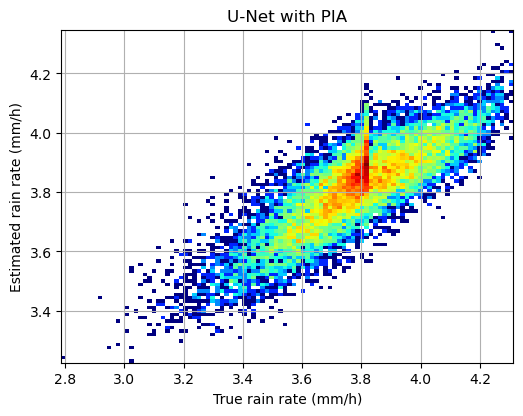

In [143]:
print(y_.shape)
print(pRate[i_test,:].shape)
print(np.corrcoef(pRate[i_test,-1],y_[:,-1,0]))
import matplotlib.pyplot as plt
import matplotlib
plt.figure(figsize=(10,10))
ax=plt.subplot(2,2,1)
pRate_=scalerPRate.inverse_transform(y_[:,:,0])
pRate_test_=scalerPRate.inverse_transform(y_test[:,:,0])
h1=plt.hist2d(pRate_test_[:,-1],(pRate_[:,-1]),bins=100,cmap='jet',norm=matplotlib.colors.LogNorm())
ax.set_aspect('equal')
#plt.xlim(0,180)
#plt.ylim(0,180)
plt.xlabel('True rain rate (mm/h)')
plt.ylabel('Estimated rain rate (mm/h)')
plt.title('U-Net with PIA')
plt.grid()
plt.tight_layout()
plt.savefig('U-Net_with_PIA_log.png')
